In [2]:
from huggingface_hub import login
login()

Let's examine the descriptive statistics of the training data to see the ranges of values for each feature.

In [3]:
   # "Random 1": np.array([0, 0.05,  6, 0.15, 0, 32, 1, 0, 7389, 1.533854e+07, 7500])


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns
%matplotlib inline

In [5]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("nahiar/instagram_bot_detection")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Instagram_fake_profile_dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [6]:
df = dataset['train'].to_pandas()
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [7]:
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)
X = df.drop("fake",axis = 1)
y = df["fake"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state = 42, test_size = 0.2)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [9]:
from tensorflow.keras.layers import BatchNormalization, Activation
model = Sequential()
# layer 1
model.add(Dense(32,input_shape = (X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
# layer 2
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
model.summary()

# 7. Train
# Use EarlyStopping to stop training if the model stops improving
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,      # High number, but callback will stop it early
    batch_size=32,   # Standard batch size
    callbacks=[callback],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6687 - loss: 0.5895 - val_accuracy: 0.9460 - val_loss: 0.2127
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9272 - loss: 0.2136 - val_accuracy: 0.9520 - val_loss: 0.1461
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9391 - loss: 0.1658 - val_accuracy: 0.9570 - val_loss: 0.1332
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9305 - loss: 0.1980 - val_accuracy: 0.9620 - val_loss: 0.1256
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9306 - loss: 0.1791 - val_accuracy: 0.9580 - val_loss: 0.1228
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9370 - loss: 0.1762 - val_accuracy: 0.9600 - val_loss: 0.1185
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9426 - loss: 0.1593 - val_accuracy: 0.9620 - val_loss: 0.1200
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9376 - loss: 0.1662 - val_accu

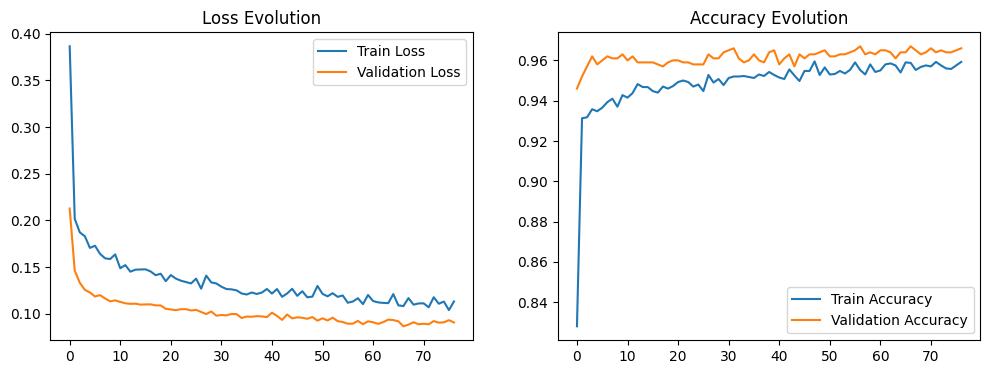

In [10]:
# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


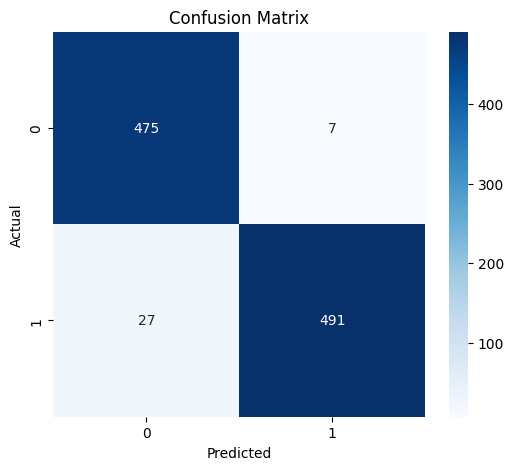

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Make predictions on the test set
predictions = model.predict(X_test)

# 2. Convert probabilities (0.9, 0.2, etc.) to binary (1, 0)
# Threshold is usually 0.5
y_pred_binary = (predictions > 0.5).astype(int)

# 3. Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# 4. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Print detailed report

In [12]:
model.save('instagram_fake_detector.h5')

# Save the Scaler (Crucial! You need this to normalize new data later)
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [13]:
all_records = {
    "Person 1": np.array([1, 0.25,  7, 0, 0, 19, 0, 1, 0, 277, 220]), # vini
    "Person 2": np.array([1, 0.17, 22, 0, 0, 37, 0, 1, 7, 343, 308]), # var
    "Person 3": np.array([1, 0.16, 13, 0, 0, 0,  0, 1, 0, 302, 736]), # vab
    "Person 4": np.array([1, 0.11, 17, 0, 0, 0,  0, 1, 0, 127, 247]), # sup
    "Random 1": np.array([0, 0.05,  6, 0.15, 0, 32, 1, 0, 126, 6000, 7500]) # Suspicious
}

names = list(all_records.keys())
custom_data = np.array(list(all_records.values()))

# 3. Scaling the data
custom_data_scaled = scaler.transform(custom_data)

# 4. Make Predictions
predictions = model.predict(custom_data_scaled)

# 5. Print Results nicely
print("-" * 50)
print(f"{'Name':<15} | {'Probability (Fake)':<20} | {'Verdict'}")
print("-" * 50)

for i, name in enumerate(names):
    prob_fake = predictions[i][0]

    # If probability > 0.5, we classify as Fake
    verdict = "FAKE ACCOUNT" if prob_fake > 0.5 else "Real Account"

    # Color code for readability (optional, works in Jupyter)
    # High probability of fake = usually red flags
    print(f"{name:<15} | {prob_fake:.8f}           | {verdict}")

print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
--------------------------------------------------
Name            | Probability (Fake)   | Verdict
--------------------------------------------------
Person 1        | 0.06602295           | Real Account
Person 2        | 0.00023484           | Real Account
Person 3        | 0.00787774           | Real Account
Person 4        | 0.00442289           | Real Account
Random 1        | 0.85890639           | FAKE ACCOUNT
--------------------------------------------------
